In [1]:
import sys, os

import torch
import torchmetrics
import pytorch_lightning as pl
import schnetpack as spk

import spainn

from ase.db import connect

In [2]:
torch.cuda.is_available() and torch.version.cuda

'12.0'

In [3]:
should_train_forces = True

dbpath = '/nc/Cyanine/all_via_module_interface.db'
model_dir = '/git/cyanines/train'

model_file = os.path.join(model_dir,
    f"best_model_E{'_F' if should_train_forces else ''}")
split_file = os.path.join(model_dir, 'split.npz')

In [4]:
db = connect(dbpath)

db.metadata

{'ReferenceMethod': 'Unknown',
 '_distance_unit': 'Bohr',
 '_property_unit_dict': {'energy': 'Hartree',
  'forces': 'Hartree/Bohr',
  'nacs': '1',
  'dipoles': '1',
  'smooth_nacs': '1'},
 'n_singlets': 3,
 'n_duplets': 0,
 'n_triplets': 0}

In [5]:
db.metadata |= {
    'atomrefs': {}
}

db.metadata

{'ReferenceMethod': 'Unknown',
 '_distance_unit': 'Bohr',
 '_property_unit_dict': {'energy': 'Hartree',
  'forces': 'Hartree/Bohr',
  'nacs': '1',
  'dipoles': '1',
  'smooth_nacs': '1'},
 'n_singlets': 3,
 'n_duplets': 0,
 'n_triplets': 0,
 'atomrefs': {}}

In [6]:
try:
    os.rename(split_file, split_file + '.old')
except FileNotFoundError:
    pass

data_module = spainn.SPAINN(
    n_states = 3,
    n_nacs = 3, # 0->1, 0->2, 1->2
    datapath = dbpath,
    batch_size = 1,
    num_train = 0.7,
    num_val = 0.1,
    split_file=split_file,
    splitting = spk.data.splitting.RandomSplit(),
    load_properties =
        ['energy', 'forces']
        if should_train_forces
        else ['energy'],
    transforms = [
        spk.transform.ASENeighborList(cutoff=5.0),
        spk.transform.RemoveOffsets(
            spainn.SPAINN.energy,
            remove_mean=True,
            remove_atomrefs=False
            ),
        spk.transform.CastTo32(),
    ]
)

data_module.prepare_data()
data_module.setup()

100%|████████████████████████████████████████| 777/777 [00:01<00:00, 423.96it/s]

{'energy': (tensor([-15.9332, -15.9277, -15.9236], dtype=torch.float64), tensor([0.0017, 0.0013, 0.0013], dtype=torch.float64))}


In [7]:
properties = data_module.dataset[0]
print(*[f'{k:>20}\t{properties[k].shape}' for k in properties], sep='\n')

                _idx	torch.Size([1])
              energy	torch.Size([1, 3])
              forces	torch.Size([24, 3, 3])
            _n_atoms	torch.Size([1])
     _atomic_numbers	torch.Size([24])
          _positions	torch.Size([24, 3])
               _cell	torch.Size([1, 3, 3])
                _pbc	torch.Size([3])


In [8]:
n_atom_basis = 30
cutoff = 5.0

pairwise_distance = spk.atomistic.PairwiseDistances()

In [9]:
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff)

schnet = spk.representation.SchNet(
    n_atom_basis=n_atom_basis,
    n_interactions=3,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
)

In [10]:
pred_energy = spainn.Atomwise(
    n_in=n_atom_basis,
    n_out=3,
    output_key=spainn.SPAINN.energy,
    n_layers=3,
)

if should_train_forces:
    pred_forces = spainn.Forces(
        energy_key=spainn.SPAINN.energy,
        force_key=spainn.SPAINN.forces,
    )

In [11]:
nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=
        [pred_energy, pred_forces]
        if should_train_forces
        else [pred_energy],
    input_dtype_str='float32',
    do_postprocessing=True,
    postprocessors=[
        spk.transform.AddOffsets(spainn.SPAINN.energy, add_mean=True, add_atomrefs=False),
        spk.transform.CastTo64(),
    ],
)

In [12]:
output_energy = spk.task.ModelOutput(
    name=spainn.SPAINN.energy,
    loss_fn=torch.nn.MSELoss(),
    # loss_fn=torch.nn.MAELoss(),
    # loss_weight=0.01,
    loss_weight=1,
    metrics={
        "MAE": torchmetrics.MeanAbsoluteError(),
    },
)

if should_train_forces:
    output_forces = spk.task.ModelOutput(
        name=spainn.SPAINN.forces,
        loss_fn=torch.nn.MSELoss(),
        loss_weight=0.99,
        metrics={
            "MAE": torchmetrics.MeanAbsoluteError(),
        },
    )

In [13]:
torch.set_float32_matmul_precision('medium')

task = spk.task.AtomisticTask(
    model=nnpot,
    outputs=
        [output_energy, output_forces]
        if should_train_forces
        else [output_energy],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4},
    scheduler_monitor="val_loss",
)

callbacks = [
    spk.train.ModelCheckpoint(
        model_path=model_file,
        save_top_k=1,
        monitor="val_loss"
    )
]

# import warnings; warnings.simplefilter('ignore')
trainer = pl.Trainer(
    log_every_n_steps=1,
    callbacks=callbacks,
    logger=pl.loggers.TensorBoardLogger(save_dir=model_dir),
    default_root_dir=model_dir,
    max_epochs=100, # for testing, we restrict the number of epochs
)

trainer.fit(task, datamodule=data_module)

/home/troehr/miniforge3/envs/spainn/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 16.6 K
1 | outputs | ModuleList             | 0     
---------------------------------------------------
16.6 K    Trainable params
0         Non-trainable params
16.6 K    Total params
0.066     Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/troehr/miniforge3/envs/spainn/lib/python3.10/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


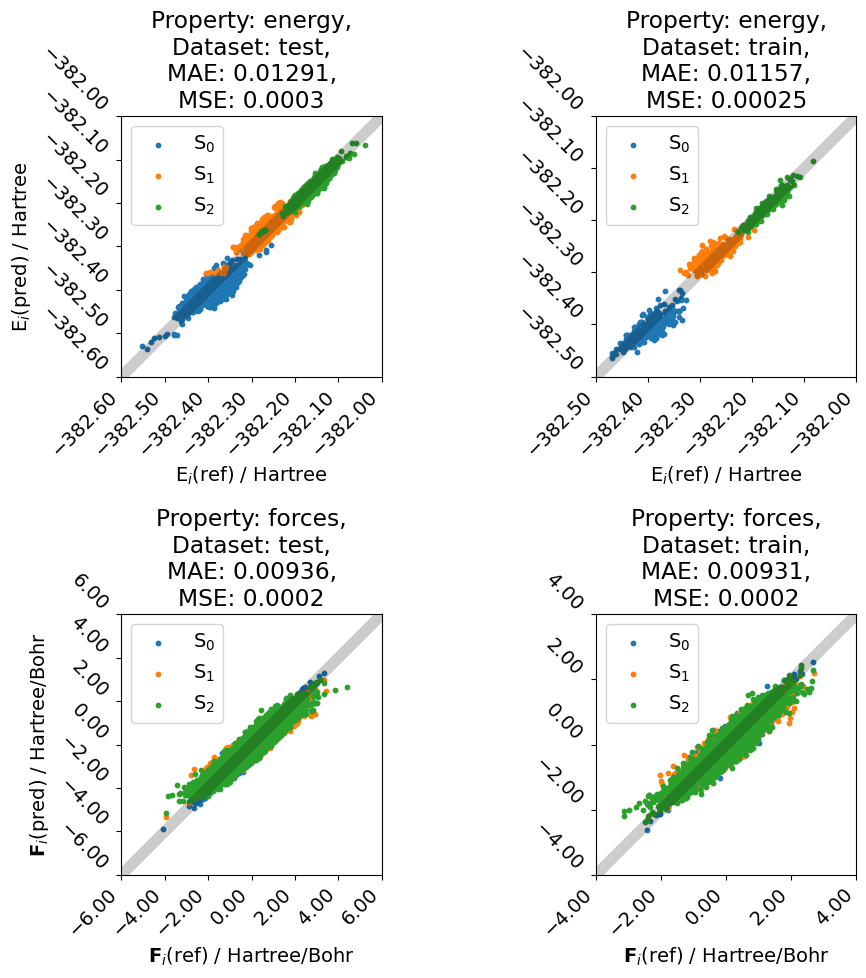

In [14]:
import spainn.plotting as sp

plotter = sp.PlotMAE(
    database = dbpath,
    split_file = split_file,
    model_file = model_file,
    cutoff = cutoff,
    properties2plot =
        ['energy', 'forces']
        if should_train_forces
        else ['energy'],
    subset2plot = ['test', 'train']
)

plotter.plot()